In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import numpy as np

import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('big_mart_train.csv')

In [3]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

___

### Impute Missing Weights

There are quite a few missing values for item weight.  The solution will be to create a table grouped by item_identifier to reference for missing values. 

In [5]:
lookup_weight_values = data.iloc[:,0:2].groupby(by='Item_Identifier').max()

In [6]:
imputed_data = data

In [7]:
imputed_data = imputed_data.merge(lookup_weight_values,on='Item_Identifier')

In [8]:
imputed_data = imputed_data.drop(columns=['Item_Weight_x'])

In [9]:
imputed_data.rename(columns={'Item_Weight_y': 'Item_Weight'}, inplace=True)

In [10]:
imputed_data.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.3
1,FDA15,Low Fat,0.016055,Dairy,250.2092,OUT045,2002,NaN,Tier 2,Supermarket Type1,5976.2208,9.3
2,FDA15,Low Fat,0.016019,Dairy,248.5092,OUT035,2004,Small,Tier 2,Supermarket Type1,6474.2392,9.3
3,FDA15,Low Fat,0.016088,Dairy,249.6092,OUT018,2009,Medium,Tier 3,Supermarket Type2,5976.2208,9.3
4,FDA15,Low Fat,0.026818,Dairy,248.9092,OUT010,1998,NaN,Tier 3,Grocery Store,498.0184,9.3


---
### Outlet Size Results

I chose these manually because of the low number of cases to model.  There is a better method I'm sure, but this is quick and should be close enough for the time being. 

* Outlet 10 Medium....only 1 other grocery store.  Both are similar and the other is Medium.
* Outlet 17 small...less sales than OUTO35(small)
* Outlet 45 small...lowest sales for Tier 2 Supermarket Type1

In [11]:
#total sales by Outlet_Identifier
round(imputed_data.groupby('Outlet_Identifier')["Item_Outlet_Sales"].sum(),2)

Outlet_Identifier
OUT010     188340.17
OUT013    2142663.58
OUT017    2167465.29
OUT018    1851822.83
OUT019     179694.09
OUT027    3453926.05
OUT035    2268122.94
OUT045    2036725.48
OUT046    2118395.17
OUT049    2183969.81
Name: Item_Outlet_Sales, dtype: float64

In [12]:
#sales by outlet_size
round(imputed_data.groupby(['Outlet_Size', 'Outlet_Identifier'])['Item_Outlet_Sales'].sum(),2)

Outlet_Size  Outlet_Identifier
High         OUT013               2142663.58
Medium       OUT018               1851822.83
             OUT027               3453926.05
             OUT049               2183969.81
Small        OUT019                179694.09
             OUT035               2268122.94
             OUT046               2118395.17
Name: Item_Outlet_Sales, dtype: float64

In [13]:
#by location_type
round(imputed_data.groupby(['Outlet_Location_Type','Outlet_Identifier'])["Item_Outlet_Sales"].sum(),2)

Outlet_Location_Type  Outlet_Identifier
Tier 1                OUT019                179694.09
                      OUT046               2118395.17
                      OUT049               2183969.81
Tier 2                OUT017               2167465.29
                      OUT035               2268122.94
                      OUT045               2036725.48
Tier 3                OUT010                188340.17
                      OUT013               2142663.58
                      OUT018               1851822.83
                      OUT027               3453926.05
Name: Item_Outlet_Sales, dtype: float64

In [14]:
#by outlet_type
round(imputed_data.groupby(['Outlet_Type','Outlet_Identifier'])["Item_Outlet_Sales"].sum(),2)

Outlet_Type        Outlet_Identifier
Grocery Store      OUT010                188340.17
                   OUT019                179694.09
Supermarket Type1  OUT013               2142663.58
                   OUT017               2167465.29
                   OUT035               2268122.94
                   OUT045               2036725.48
                   OUT046               2118395.17
                   OUT049               2183969.81
Supermarket Type2  OUT018               1851822.83
Supermarket Type3  OUT027               3453926.05
Name: Item_Outlet_Sales, dtype: float64

In [15]:
#Need to impute OUT010, OUT017, OUT045
imputed_data.groupby('Outlet_Identifier')['Outlet_Size'].max()

Outlet_Identifier
OUT010       NaN
OUT013      High
OUT017       NaN
OUT018    Medium
OUT019     Small
OUT027    Medium
OUT035     Small
OUT045       NaN
OUT046     Small
OUT049    Medium
Name: Outlet_Size, dtype: object

In [16]:
imputed_data['Outlet_Size'] = np.where(imputed_data['Outlet_Identifier'] == "OUT010", 
         "Medium", imputed_data['Outlet_Size'])

In [17]:
imputed_data['Outlet_Size'] = np.where(imputed_data['Outlet_Identifier'] == "OUT017", 
         "Small", imputed_data['Outlet_Size'])

In [18]:
imputed_data['Outlet_Size'] = np.where(imputed_data['Outlet_Identifier'] == "OUT045", 
         "Small", imputed_data['Outlet_Size'])

In [19]:
#confirm that OUT017 is now Small
imputed_data.loc[imputed_data['Outlet_Identifier'] == 'OUT017'][:5]

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight
7,FDA15,LF,0.016113,Dairy,248.8092,OUT017,2007,Small,Tier 2,Supermarket Type1,5976.2208,9.300
9,DRC01,Regular,0.019309,Soft Drinks,49.0692,OUT017,2007,Small,Tier 2,Supermarket Type1,1478.0760,5.920
31,NCD19,Low Fat,0.013254,Household,56.4614,OUT017,2007,Small,Tier 2,Supermarket Type1,828.9210,8.930
34,FDP36,Regular,0.091688,Baking Goods,49.0008,OUT017,2007,Small,Tier 2,Supermarket Type1,860.2136,10.395
41,FDO10,Regular,0.012824,Snack Foods,55.5588,OUT017,2007,Small,Tier 2,Supermarket Type1,916.1408,13.650


---
* Drop cases with missing weights...should be 4

In [20]:
# 4 missing values
imputed_data.isnull().sum()

Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Weight                  4
dtype: int64

In [21]:
#only rows with missing values
imputed_data[imputed_data['Item_Weight'].isnull()]

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight
4125,FDN52,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564,NaN
6440,FDK57,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280,NaN
8278,FDE52,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046,NaN
8463,FDQ60,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098,NaN


In [22]:
# drop rows with missing values (only 4 in this case)
imputed_data = imputed_data.dropna()

___

* Drop Variables
   1. Item Fat Content
   2. Item Type
   3. Outlet Identifier
* Encode dummy variables
* Split lable from data

In [23]:
data_encoded = imputed_data

In [24]:
#item identifier isn't useful in this context
data_encoded = data_encoded.drop(['Item_Identifier', 'Item_Type', 'Item_Fat_Content', 'Outlet_Identifier'], axis='columns')

In [25]:
#encode non_numeric types to their own column with binary values
data_encoded = pd.get_dummies(data_encoded)

In [26]:
data_label = data_encoded.pop('Item_Outlet_Sales')

In [27]:
#add the label to the end of the DF
data_encoded['Item_Outlet_Sales'] = data_label

In [28]:
data_encoded.head()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Weight,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,0.016047,249.8092,1999,9.3,0,1,0,1,0,0,0,1,0,0,3735.1380
1,0.016055,250.2092,2002,9.3,0,0,1,0,1,0,0,1,0,0,5976.2208
2,0.016019,248.5092,2004,9.3,0,0,1,0,1,0,0,1,0,0,6474.2392
3,0.016088,249.6092,2009,9.3,0,1,0,0,0,1,0,0,1,0,5976.2208
4,0.026818,248.9092,1998,9.3,0,1,0,0,0,1,1,0,0,0,498.0184


___

### Prepare to model

* Create x & y 
* Split data into train / test

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X, y = data_encoded.iloc[:,:-1],data_encoded.iloc[:,-1]

In [31]:
seed = 7
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

___

### XGBoost

In [32]:
import xgboost as xgb

In [33]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [34]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [35]:
xgb_model = xg_reg.fit(x_train,y_train)
y_xgb = xgb_model.predict(x_test)

___

### SVM
[docs](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)

In [36]:
from sklearn.svm import SVR

In [37]:
svr_lin = SVR(kernel='linear', C=1e3)
linear_model = svr_lin.fit(x_train, y_train)
y_lin = linear_model.predict(x_test)

---

### Evaluate Models

1. y_xgb
2. y_lin

In [38]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy import sqrt

___

XGBoost

In [39]:
r2_score(y_test, y_xgb)

0.596012479230885

In [40]:
sqrt(mean_squared_error(y_test, y_xgb))

1073.8260961997253

with outlet_location_type = 1073.826

With all 48 features, accuracy was 1074.68....slightly better with a simple model. Outlet_Identifier will likely be important internal to the business where geographic information could be added.

---
### Feature Importance

In [41]:
from xgboost import plot_importance

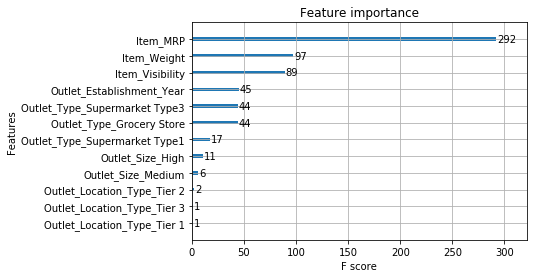

In [42]:
plot_importance(xgb_model)

___

Linear

In [43]:
r2_score(y_test, y_lin)

0.4658207632678595

In [44]:
sqrt(mean_squared_error(y_test, y_lin))

1234.7910718798191

___
Plot Results

In [45]:
import matplotlib.pyplot as plt

### Actual vs Predicted

Top 2 models, linear and xgb, against actuals.  

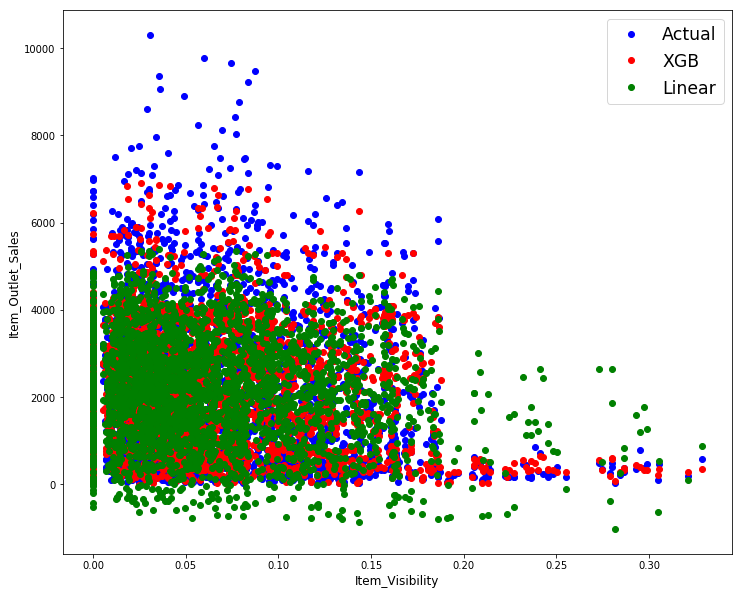

In [46]:
plt.figure(figsize=(12,10))
plt.plot(x_test['Item_Visibility'], y_test, 'o', color='b', label='Actual')
plt.plot(x_test['Item_Visibility'], y_xgb, 'o', color='r', label='XGB')
plt.plot(x_test['Item_Visibility'], y_lin, 'o', color='g', label='Linear')
plt.xlabel("Item_Visibility", fontsize='large')
plt.ylabel("Item_Outlet_Sales", fontsize='large')
plt.legend(fontsize='xx-large')

---
Only XGB vs Actual

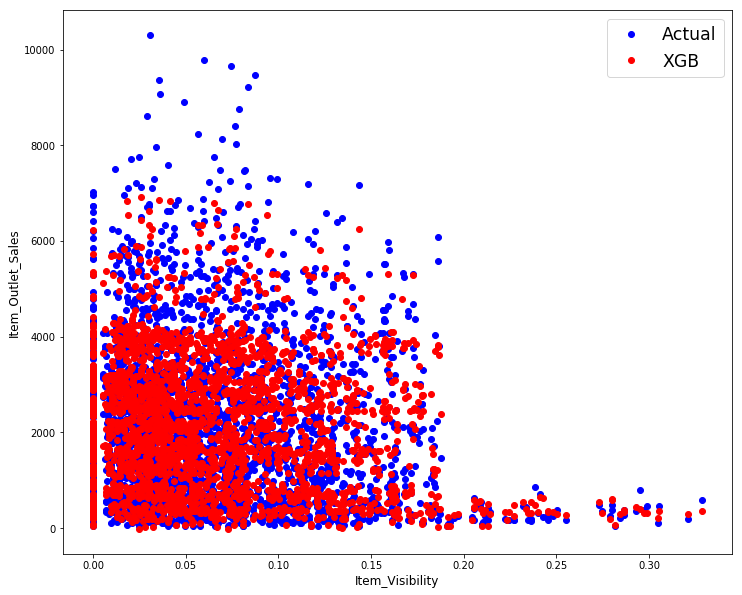

In [47]:
plt.figure(figsize=(12,10))
plt.plot(x_test['Item_Visibility'], y_test, 'o', color='b', label='Actual')
plt.plot(x_test['Item_Visibility'], y_xgb, 'o', color='r', label='XGB')
plt.xlabel("Item_Visibility", fontsize='large')
plt.ylabel("Item_Outlet_Sales", fontsize='large')
plt.legend(fontsize='xx-large')